## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as im
import pickle
%matplotlib inline


### Compute the camera calibration using chessboard images

In [2]:
# Object points
objp        = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob("camera_cal/*.jpg")

for idx, filename in enumerate(images):
    # Read image
    image = im.imread(filename)
    # Convert to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Find image points
    isFound, points = cv2.findChessboardCorners(gray, (9,6), None)
    
    # Check if we found an image
    if isFound == True:
        objpoints.append(objp)
        imgpoints.append(points)
        
        # Draw point on the image
        cv2.drawChessboardCorners(image, (8,6), points, isFound)
        
        # Plot image
        cv2.imshow('image', image)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

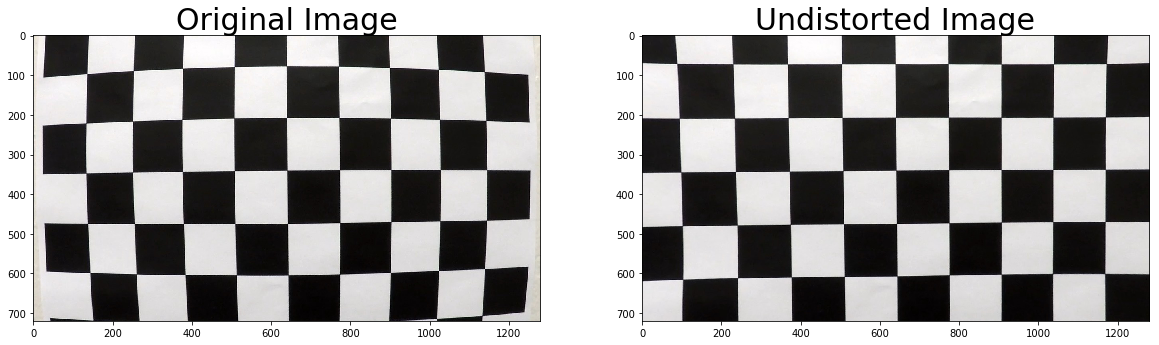

In [3]:
# Read test image
image = im.imread("camera_cal/calibration1.jpg")
size  = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)

dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal//wide_dist_pickle.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply a distortion correction to raw images

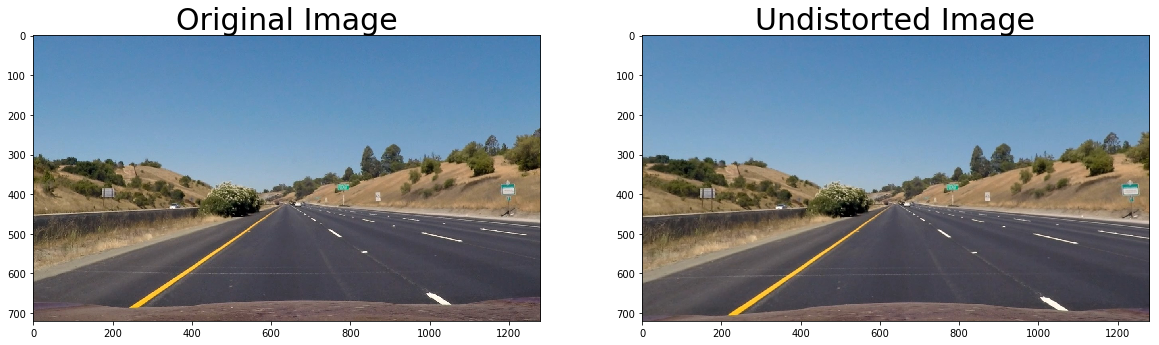

In [4]:
image = im.imread("./test_images/straight_lines1.jpg")
und_image =  cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_image)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image

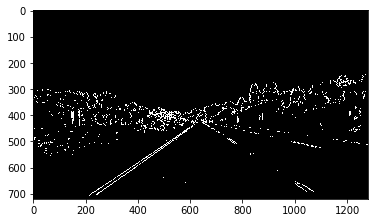

In [5]:
# Gray scale
gray = cv2.cvtColor(und_image, cv2.COLOR_RGB2GRAY)
# Take gradint x direction
sobelx = cv2.Sobel(gray, cv2.CV_64F,1, 0)
sobely = cv2.Sobel(gray, cv2.CV_64F,1,0)
# ABS value
abs_sobel = np.sqrt(sobelx**2 + sobely**2)
# scale gradint
scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))

thresh_max = 170
thresh_min = 26
sxbinary   = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

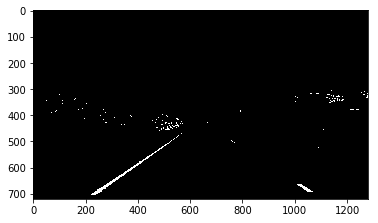

In [6]:
thresh = (170,255)
HLS    = cv2.cvtColor(und_image, cv2.COLOR_RGB2HLS)
H      = HLS[:,:,0]
L      = HLS[:,:,1]
S      = HLS[:,:,2]
binary = np.zeros_like(H)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary, cmap='gray')


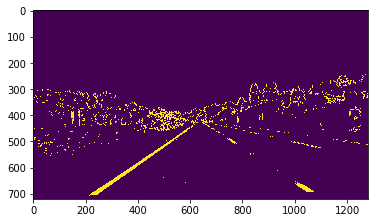

In [7]:
combined_binary = np.zeros_like(binary)
combined_binary[(binary==1) | (sxbinary==1)] = 1
plt.imshow(combined_binary)

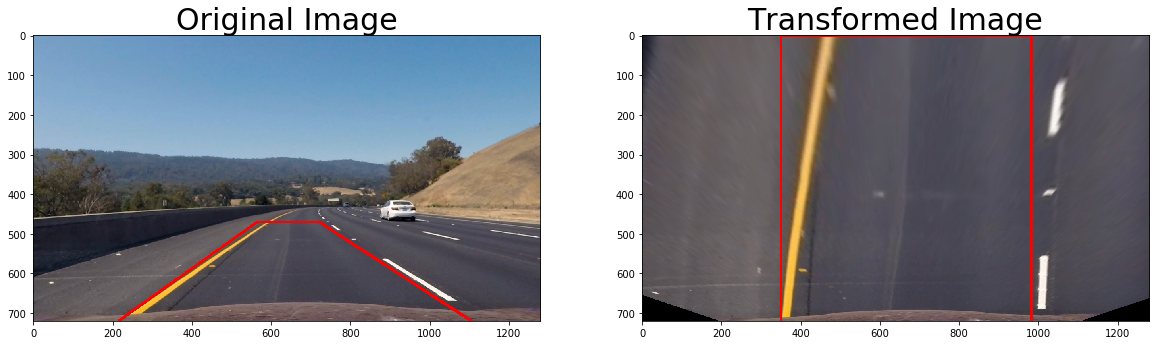

In [27]:
image = im.imread("./test_images/test3.jpg")
und_image =  cv2.undistort(image, mtx, dist, None, mtx)

src = np.float32([[(215, 720), (565, 470), (720, 470), (1105, 720)]])
dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

# 1. Get transormation matrix
M = cv2.getPerspectiveTransform(src,dst)

# 2. Compute the inverse perspective transform
wraped = cv2.warpPerspective(und_image, M, (und_image.shape[1], und_image.shape[0]), flags=cv2.INTER_LINEAR)

cv2.line(und_image,(215, 720),(565, 470),(255,0,0),5)
cv2.line(und_image,(565, 470),(720, 470),(255,0,0),5)
cv2.line(und_image,(720, 470),(1105, 720),(255,0,0),5)

cv2.line(wraped,(350, 720),(350, 0),(255,0,0),5)
cv2.line(wraped,(350, 0),(980, 0),(255,0,0),5)
cv2.line(wraped,(980, 0),(980, 720),(255,0,0),5)
#cv2.rectangle(und_image, (200, 720), (720, 470), (0, 255, 0), 2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(und_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(wraped)
ax2.set_title('Transformed Image', fontsize=30)